KMeans results (k=2..10):
    silhouette  calinski_harabasz  davies_bouldin
k                                                
2     0.551150       13137.459108        0.704660
3     0.522780       11524.161622        0.750412
4     0.439417       10935.519097        0.842657
5     0.384763       10700.033154        0.886484
6     0.397381       10407.235266        0.834219
7     0.372043       10284.337968        0.866289
8     0.352643       10137.022983        0.902747
9     0.354264        9784.942573        0.910523
10    0.338470        9647.649758        0.942207

Best k by silhouette: 2 (silhouette=0.5512)


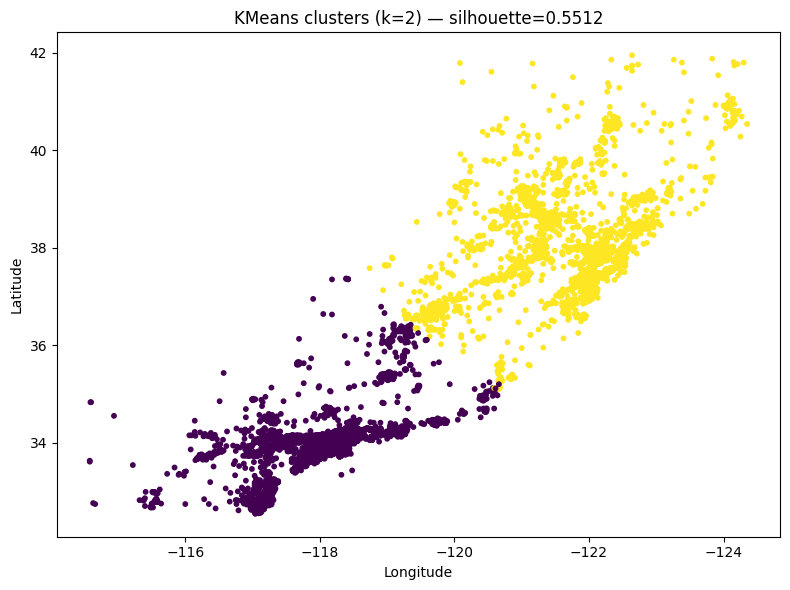

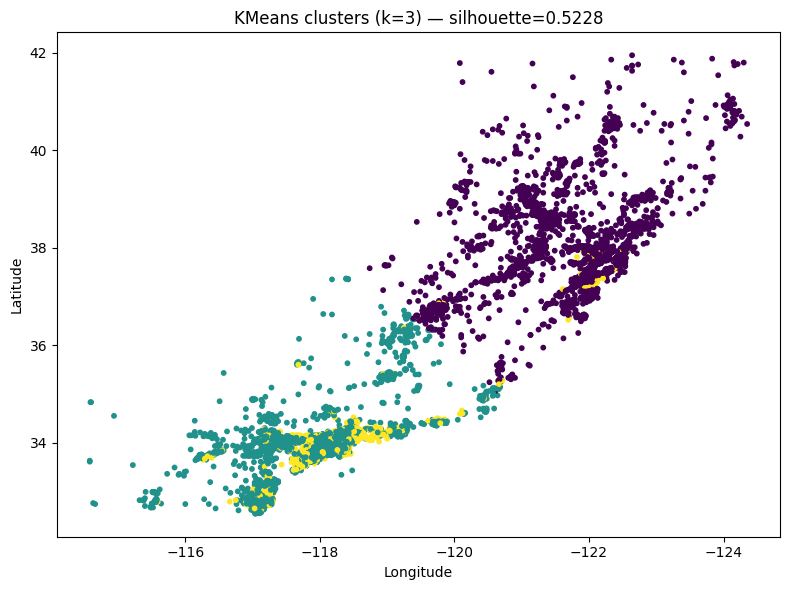

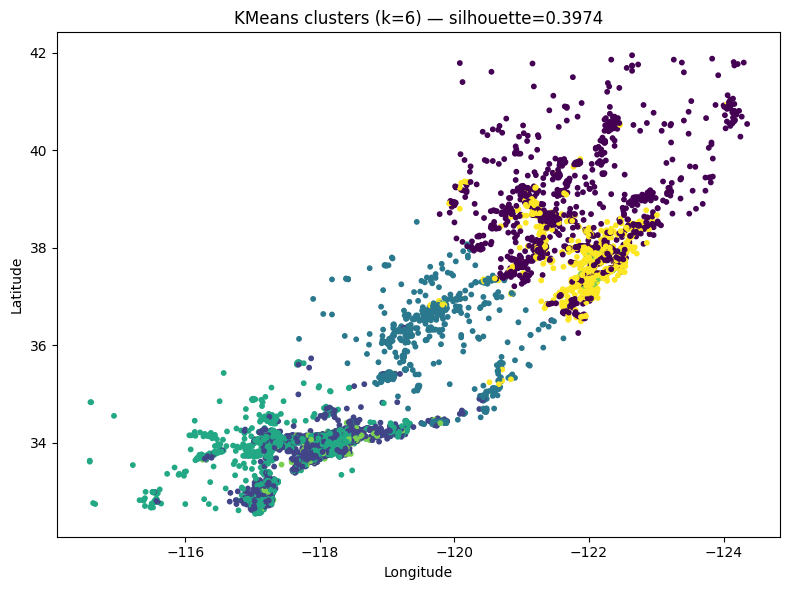


Cluster statistics for best KMeans (by silhouette):
   cluster  n_points  mean_longitude  mean_latitude  mean_median_income  \
0        0      5843     -118.008650      33.931942            3.933098   
1        1      4157     -121.717467      37.957125            3.775980   

   median_median_income  
0                3.5978  
1                3.4561  

Top DBSCAN results (sorted by silhouette; NaNs at bottom):
    eps  min_samples  n_clusters  silhouette  calinski_harabasz  \
11  0.4           15           2    0.639562         268.094444   
10  0.4           10           2    0.639009         267.232739   
15  0.5           15           2    0.636868         276.575243   
9   0.4            8           3    0.571320         163.131090   
3   0.2           15          10    0.127852        2000.804265   
8   0.4            5           4   -0.061437         130.260060   
2   0.2           10          12   -0.085748        1740.450341   
6   0.3           10           4   -0.102857   

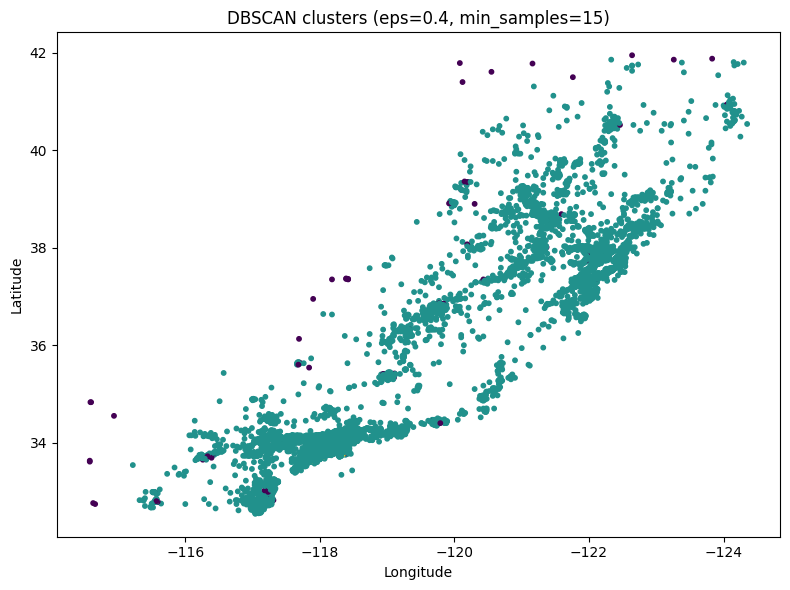


Comparison (best KMeans vs best DBSCAN candidate):
   method                   params  silhouette  calinski_harabasz  \
0  KMeans                      k=2    0.551150       13137.459108   
1  DBSCAN  eps=0.4, min_samples=15    0.639562         268.094444   

   davies_bouldin  
0         0.70466  
1         0.30269  


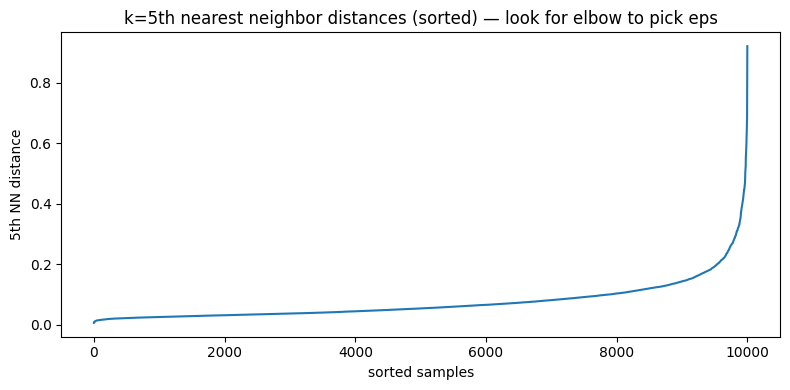


Script finished. Inspect tables & plots above.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# 1) Load dataset
data = fetch_california_housing(as_frame=True)   # requires internet the first time
df = data.frame[['Longitude','Latitude','MedInc']].rename(columns={'MedInc':'median_income'})

# Optional: sample for speed (comment out to use all rows)
n_sample = 10000
if len(df) > n_sample:
    df = df.sample(n_sample, random_state=RANDOM_STATE).reset_index(drop=True)

# 2) Prepare features & scale
X = df[['Longitude','Latitude','median_income']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) KMeans: try k range and compute silhouette score
k_range = list(range(2, 11))
k_results = []
k_models = {}
for k in k_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    k_results.append({'k':k, 'silhouette':sil, 'calinski_harabasz':ch, 'davies_bouldin':db})
    k_models[k] = (km, labels)

k_df = pd.DataFrame(k_results).set_index('k').sort_index()
print("KMeans results (k=2..10):")
print(k_df)

best_k = k_df['silhouette'].idxmax()
print(f"\nBest k by silhouette: {best_k} (silhouette={k_df.loc[best_k,'silhouette']:.4f})")

# 4) Visualize KMeans clusters for several k values (each in its own figure)
plot_ks = [2, 3, best_k, 6]  # adjust list as you like
plot_ks = sorted(set([k for k in plot_ks if k in k_models]))

for k in plot_ks:
    km, labels = k_models[k]
    plt.figure(figsize=(8,6))
    plt.scatter(df['Longitude'], df['Latitude'], c=labels, s=10)
    plt.title(f'KMeans clusters (k={k}) — silhouette={k_df.loc[k,"silhouette"]:.4f}')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.gca().invert_xaxis()  # common for CA maps (optional)
    plt.tight_layout()
    plt.show()

# 5) Cluster stats for best KMeans
km_best, labels_best = k_models[best_k]
df_k = df.copy()
df_k['cluster'] = labels_best
cluster_stats = df_k.groupby('cluster').agg(
    n_points=('Longitude','size'),
    mean_longitude=('Longitude','mean'),
    mean_latitude=('Latitude','mean'),
    mean_median_income=('median_income','mean'),
    median_median_income=('median_income','median')
).reset_index().sort_values('cluster')
print("\nCluster statistics for best KMeans (by silhouette):")
print(cluster_stats)

# 6) DBSCAN: grid search (eps and min_samples). Compute silhouette only when >=2 clusters.
eps_values = [0.2,0.3,0.4,0.5,0.6,0.8,1.0]   # on scaled data units
min_samples_values = [5,8,10,15]
dbscan_results = []
dbscan_models = {}
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)
        n_clusters = len([l for l in set(labels) if l != -1])
        if n_clusters >= 2:
            # silhouette computed only on non-noise points
            mask = labels != -1
            sil = silhouette_score(X_scaled[mask], labels[mask])
            ch = calinski_harabasz_score(X_scaled[mask], labels[mask])
            dbi = davies_bouldin_score(X_scaled[mask], labels[mask])
        else:
            sil = np.nan; ch = np.nan; dbi = np.nan
        dbscan_results.append({'eps':eps, 'min_samples':ms, 'n_clusters':n_clusters,
                               'silhouette':sil, 'calinski_harabasz':ch, 'davies_bouldin':dbi})
        dbscan_models[(eps,ms)] = (db, labels)

db_df = pd.DataFrame(dbscan_results).sort_values(['silhouette'], ascending=False)
print("\nTop DBSCAN results (sorted by silhouette; NaNs at bottom):")
print(db_df.head(10))

# pick the best DBSCAN row with a valid silhouette
db_valid = db_df.dropna(subset=['silhouette'])
if not db_valid.empty:
    best_db = db_valid.iloc[0]
    best_db_params = (best_db['eps'], int(best_db['min_samples']))
    best_db_model, best_db_labels = dbscan_models[best_db_params]
    print(f"\nBest DBSCAN params by silhouette: eps={best_db_params[0]}, min_samples={best_db_params[1]} (silhouette={best_db['silhouette']:.4f}, n_clusters={best_db['n_clusters']})")
else:
    best_db_params = None
    print("\nNo DBSCAN configuration produced >=2 clusters (on sampled/scaled data).")

# Visualize best DBSCAN if valid
if best_db_params is not None:
    labels = best_db_labels
    plt.figure(figsize=(8,6))
    plt.scatter(df['Longitude'], df['Latitude'], c=labels, s=10)
    plt.title(f'DBSCAN clusters (eps={best_db_params[0]}, min_samples={best_db_params[1]})')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

# 7) Compare numeric metrics (best KMeans vs best DBSCAN)
best_k_sil = k_df.loc[best_k,'silhouette']
best_db_sil = db_valid.iloc[0]['silhouette'] if (not db_valid.empty) else np.nan

comparison = pd.DataFrame([
    {'method':'KMeans', 'params':f'k={best_k}', 'silhouette':best_k_sil,
     'calinski_harabasz':k_df.loc[best_k,'calinski_harabasz'], 'davies_bouldin':k_df.loc[best_k,'davies_bouldin']},
    {'method':'DBSCAN', 'params':f'eps={best_db_params[0]}, min_samples={best_db_params[1]}' if best_db_params else 'n/a',
     'silhouette':best_db_sil,
     'calinski_harabasz':(db_valid.iloc[0]['calinski_harabasz'] if (not db_valid.empty) else np.nan),
     'davies_bouldin':(db_valid.iloc[0]['davies_bouldin'] if (not db_valid.empty) else np.nan)}
])

print("\nComparison (best KMeans vs best DBSCAN candidate):")
print(comparison)

# 8) Extra: if you want to estimate a sensible eps for DBSCAN, use nearest neighbors distances plot:
def plot_knn_dist(Xs, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(Xs)
    distances, indices = nbrs.kneighbors(Xs)
    d = np.sort(distances[:, k-1])
    plt.figure(figsize=(8,4))
    plt.plot(d)
    plt.title(f'k={k}th nearest neighbor distances (sorted) — look for elbow to pick eps')
    plt.ylabel(f'{k}th NN distance')
    plt.xlabel('sorted samples')
    plt.tight_layout()
    plt.show()

plot_knn_dist(X_scaled, k=5)

# End
print("\nScript finished. Inspect tables & plots above.")